In [1]:
%matplotlib notebook

from islpy import *
import numpy as np
from IPython.display import Image
from simplify.plot import plot_3d_sets
from islpy import BasicSet, BasicMap

## Homothetic Scaling

We would like to be able to detect whether two ISL sets are homothetic. In other words, we would like to say whether one set a homothetic scaling of the other. A homothetic transformation of set $A$ is an affine transformation where every point in $A$ is scaled by the **same** factor relative to some homothetic center.

For example, the following image illustrates homothetic scaling relative to the origin.

<IPython.core.display.Javascript object>


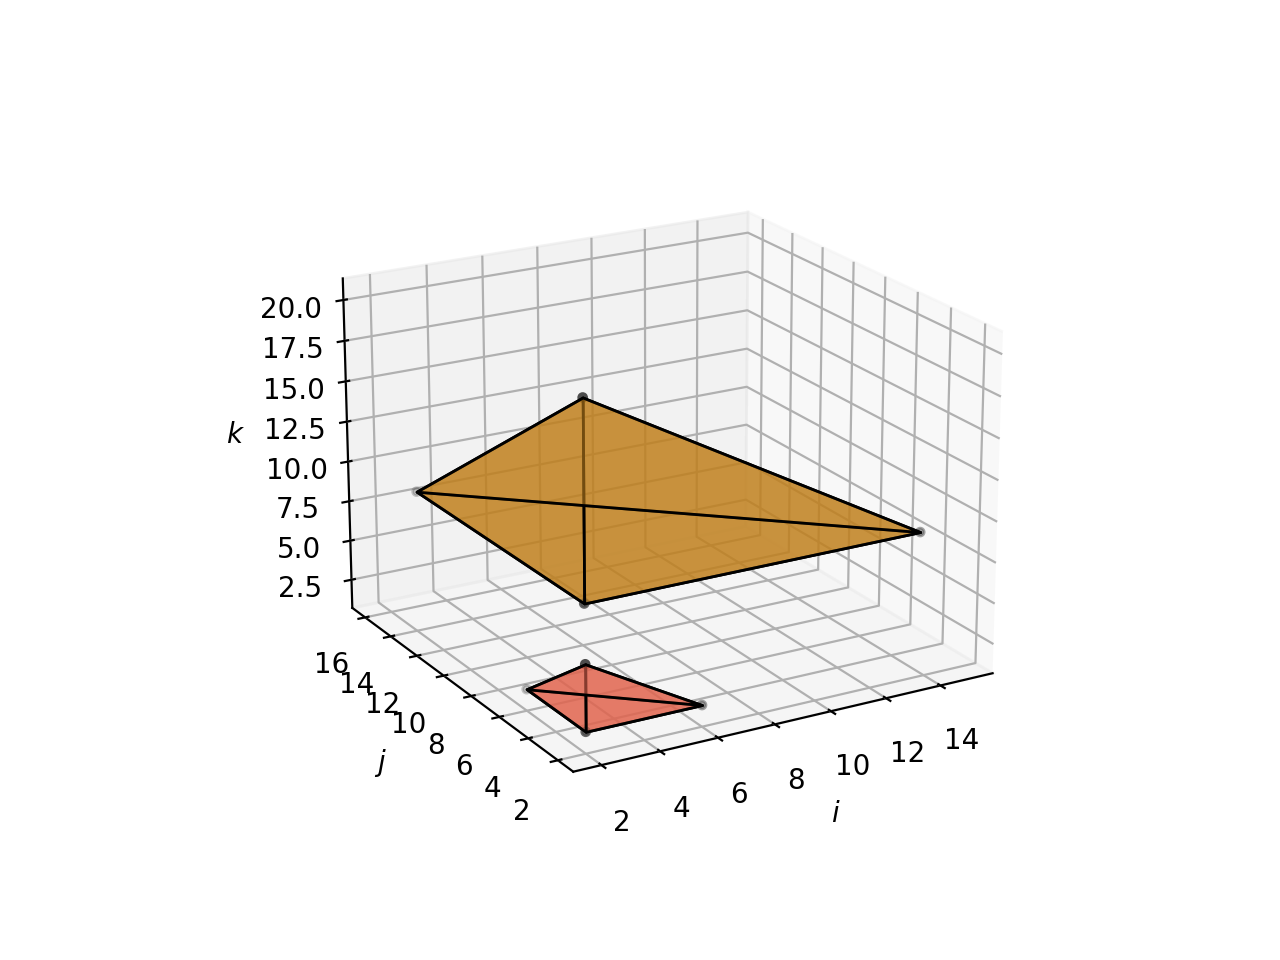

In [2]:
s0 = BasicSet('[N]->{[i,j,k] : N=4 and 0<=i,j,k and i+j+k<=N }').apply(BasicMap('[N]->{[i,j,k]->[i+2,j+2,k+2]}'))
s1 = BasicSet('[N]->{[i,j,k] : N=4 and 0<=i,j,k and i+j+k<=3N }').apply(BasicMap('[N]->{[i,j,k]->[i+3,j+4,k+8]}'))

plot_3d_sets([s0, s1])

## Helper functions

The following funtions are used here. Everything below uses the python bindings to ISL$^2$. 

In [3]:
def multi_aff_to_vec(maff, num_indices, num_params):
    # given maff: [((A1)N + (B1)M + ... + (C1)), ((A2)N + (B2)M + ... + (C2)), ... ]
    # return vec: [A1, B1, ..., C1, A2, B2, ..., C2, ... ]
    vec = []
    for i in range(num_indices):
        aff = maff.get_aff(i)
        vec += [aff.get_coefficient_val(dim_type.param, j) for j in range(num_params)] + [aff.get_constant_val()]
    return vec

In [4]:
def subtract_maffs_i(l, r, i):
    if l and r:
        return l.get_aff(i) - r.get_aff(i)
    elif l and not r:
        return l.get_aff(i)
    elif not l and r:
        return r.get_aff(i).neg()

### vertices(bset)

Given an ISL basic set (i.e., a single convex set), get the vertices in each chamber.

In [5]:
def vertices(bset, num_indices, num_params):
    chambers = []
    bset.polyhedral_hull().compute_vertices().foreach_cell(chambers.append)
    vertices = []
    for chamber in chambers:
        vertices.append([])
        chamber.foreach_vertex(vertices[-1].append)
        vertices[-1] = [v.get_expr() for v in vertices[-1]]
        # vertices are not guaranteed to be in same relative order
        # sort them in lexicographic order
        vertices[-1].sort(key=lambda v: multi_aff_to_vec(v, num_indices, num_params))
    return vertices


s = '{[i,j] : 0<=i,j<=13 }'
print('non-parametric example:', s)
for v in vertices(BasicSet(s), 2, 0)[0]:
    print(v)
print()
s = '[N] -> {[i,j] : 0<=i,j and i+j<=N }'
print('parametric example:', s)
for v in vertices(BasicSet(s), 2, 1)[0]:
    print(v)

non-parametric example: {[i,j] : 0<=i,j<=13 }
{ [(0), (0)] }
{ [(0), (13)] }
{ [(13), (0)] }
{ [(13), (13)] }

parametric example: [N] -> {[i,j] : 0<=i,j and i+j<=N }
[N] -> { [(0), (0)] }
[N] -> { [(0), (N)] }
[N] -> { [(N), (0)] }


### build_map(set_space, multi_aff_0, multi_aff_1, nparam, n_out)

Given two vertices (as multi-affine expressions), compute the map that represents the translation from one vertex to the other.

In other words, given 2D expressions like this:
* `multi_aff_0` = `(0, 0)`
* `multi_aff_1` = `(A, B)`

Produce the map:
* `{[i,j]->[i-A,j-B]}`

In [6]:
def build_map(set_space, multi_aff_0, multi_aff_1, nparam, n_out, direction=0):
    n_in = n_out
    space = Space.alloc(set_space.get_ctx(), nparam, n_in, n_out)
    for name, tuple in set_space.get_var_dict().items():
        type, pos = tuple
        space = space.set_dim_name(type, pos, name)
        if type == dim_type.out:
            space = space.set_dim_name(dim_type.in_, pos, name)

    m = BasicMap.universe(space)

    for i in range(n_in):
        if direction == 0:
            diff = subtract_maffs_i(multi_aff_1, multi_aff_0, i)
        else:
            diff = subtract_maffs_i(multi_aff_0, multi_aff_1, i)

        # can only set integer values so scale all dims by lcm denominators
        if nparam > 0:
            max_den = np.lcm.reduce([diff.get_coefficient_val(dim_type.param, j).get_den_val().to_python() for j in range(nparam)])
        else:
            max_den = diff.get_constant_val().get_den_val()
        constraint = Constraint.alloc_equality(space)
        constraint = constraint.set_coefficient_val(dim_type.out, i, max_den)
        constraint = constraint.set_coefficient_val(dim_type.in_, i, max_den * -1)
        for j in range(nparam):
            val = diff.get_coefficient_val(dim_type.param, j)
            constraint = constraint.set_coefficient_val(dim_type.param, j, val * max_den)
        constraint = constraint.set_constant_val(diff.get_constant_val() * max_den)
        m = m.add_constraint(constraint)

    return m


chamber = 0

bset_0 = BasicSet('[N] -> {[0,0]}')
bset_1 = BasicSet('[N] -> {[N,2N]}')

vertex_0 = vertices(bset_0, 2, 1)[chamber][0]
vertex_1 = vertices(bset_1, 2, 1)[chamber][0]

# ISL parametric vertices are multiple affine expressions

print(vertex_0)
print(vertex_1)

print('map:')
print(build_map(bset_0.get_space(), vertex_0, vertex_1, 1, 2))

[N] -> { [(0), (0)] }
[N] -> { [(N), (2N)] }
map:
[N] -> { [i0, i1] -> [o0, o1] : o0 = -N + i0 and o1 = -2N + i1 }


## make_integer_valued(vec)

To avoid floating point representations, we can scale any vector by the least common multiple (LCM) of denominators present among all elements. In other words, given:

vec = `[1/3, 0, 2/5, 1]`

identify that 15 is the LCM and produce:

`[5, 0, 6, 15]`

In [7]:
def make_integer_valued(vec):
    max_den = np.lcm.reduce([v.get_den_val().to_python() for v in vec])
    return [(v * max_den).to_python() for v in vec]

make_integer_valued([Val('1/3'), Val('0'), Val('2/5'), Val('1')])

[5, 0, 6, 15]

In [8]:
def homothetic(s0, s1, chamber=0, verbose=None):
    def pprint(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
    pprint('s0:', s0)
    pprint('s1:', s1)
    pprint()
    return bsets_are_homothetic(BasicSet(s0), BasicSet(s1), chamber=chamber, verbose=verbose)


## bsets_are_homothetic(bset_0, bset_1, ...)

This is the main algorithm. Reports if the set `s1` is a homothetic scaling of set `s0`. ISL's parametric vertex computation reports vertices in lexicographically descreasing order. This means that we can iterate through vertices in lexicographic order.

This only assumes that the two sets are not rotated in any way. The algorithm proceeds as follows:

1. compute the parametric vertices for each set
1. get the lexicographic minimum vertices for each set
1. compute the map $M$ from `s1`'s lexmin vertex to `s0`'s lexmin vertex
1. apply map $M$ to set `s1` to translate `s1` such that its lexmin vertex lands on `s0`'s lexmin vertex
1. treat this (now common) lexmin vertex as the homothetic center
1. for each pair of vertices between `s1` and `s0`, test if the amount by which the magnitudes of vertices differ is the same for all pairs.
1. if this amount is the same for all vertex pairs, then conlude that `s1` is a homothetic scaling of `s0`, else report otherwise.

This fails if the number of vertices differs between the two, as it should.

In [9]:
def bsets_are_homothetic(bset0, bset1, chamber=0, verbose=None):
    def pprint(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)

    space = bset0.get_space()
    num_indices = len([k for k, v in space.get_var_dict().items() if v[0] == dim_type.out])
    num_params = len([k for k, v in space.get_var_dict().items() if v[0] == dim_type.param])

    chambers_0 = vertices(bset0, num_indices, num_params)
    chambers_1 = vertices(bset1, num_indices, num_params)

    vertices_0 = chambers_0[chamber]
    vertices_1 = chambers_1[chamber]

    pprint('vertices_0:')
    [pprint(v) for v in vertices_0]
    pprint('vertices_1:')
    [pprint(v) for v in vertices_1]
    pprint()

    if len(vertices_0) != len(vertices_1):
        return False

    # vertices are sorted in increasing lexicographic order
    # translate bset1 so that it's min vertex lands on bset0's min vertex
    # the min vertex is then treated as the homothetic center
    lexmin_v0 = vertices_0[0]
    lexmin_v1 = vertices_1[0]
    m = build_map(space, lexmin_v0, lexmin_v1, num_params, num_indices)
    pprint('map:', m)
    pprint()
    translated_bset1 = bset1.apply(m)
    translated_chambers_1 = vertices(translated_bset1, num_indices, num_params)

    vertices_1 = translated_chambers_1[chamber]

    # now the min vertices are the same, take this as the homothetic center
    homothetic_center = lexmin_v0
    vertices_0 = vertices_0[1:]
    vertices_1 = vertices_1[1:]

    pprint('homothetic_center: ', homothetic_center)
    pprint()
    pprint('vertices_0:')
    [pprint(v) for v in vertices_0]
    pprint('translated_vertices_1:')
    [pprint(v) for v in vertices_1]
    pprint()

    # hstack vertex vectors relative to homothetic center
    def hstack_vertices(vertices):
        all_vecs = []
        for vertex in vertices:
            for i in range(num_indices):
                aff = vertex.get_aff(i) - homothetic_center.get_aff(i)
                all_vecs += [aff.get_coefficient_val(dim_type.param, j) for j in range(num_params)] + [aff.get_constant_val()]
        return all_vecs

    all_vecs_0 = make_integer_valued(hstack_vertices(vertices_0))
    all_vecs_1 = make_integer_valued(hstack_vertices(vertices_1))

    # to be homothetic, vec0 and vec must be linearly dependent
    mat = np.vstack((all_vecs_0, all_vecs_1))
    is_homothetic = np.linalg.matrix_rank(mat) == 1
    return is_homothetic


## Example 1

This is a homothetic scaling, and reports True.

In [10]:
print('homothetic(s0, s1): ', homothetic(
    '[N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i }',
    '[N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M and 3j>=i }',
    verbose = True
), end='\n\n')

s0: [N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i }
s1: [N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M and 3j>=i }

vertices_0:
[N, M] -> { [(0), (0)] }
[N, M] -> { [(0), (M)] }
[N, M] -> { [(N), (M)] }
[N, M] -> { [(N), (N)/3] }
vertices_1:
[N, M] -> { [(0), (0)] }
[N, M] -> { [(0), (2M)] }
[N, M] -> { [(2N), (2M)] }
[N, M] -> { [(2N), (2N)/3] }

map: [N, M] -> { [i, j] -> [i', j'] : i' = i and j' = j }

homothetic_center:  [N, M] -> { [(0), (0)] }

vertices_0:
[N, M] -> { [(0), (M)] }
[N, M] -> { [(N), (M)] }
[N, M] -> { [(N), (N)/3] }
translated_vertices_1:
[N, M] -> { [(0), (2M)] }
[N, M] -> { [(2N), (2M)] }
[N, M] -> { [(2N), (2N)/3] }

homothetic(s0, s1):  True



## Example 2

This is identical to example 1, except the bottom boundary is shifted up by 1. This is not homothetic anymore, and reports False.

In [11]:
print('homothetic(s0, s1): ', homothetic(
    '[N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i+3 }',
    '[N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M and 3j>=i+3 }',
    verbose=True
), end='\n\n')

s0: [N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i+3 }
s1: [N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M and 3j>=i+3 }

vertices_0:
[N, M] -> { [(0), (1)] }
[N, M] -> { [(0), (M)] }
[N, M] -> { [(N), (M)] }
[N, M] -> { [(N), (3 + N)/3] }
vertices_1:
[N, M] -> { [(0), (1)] }
[N, M] -> { [(0), (2M)] }
[N, M] -> { [(2N), (2M)] }
[N, M] -> { [(2N), (3 + 2N)/3] }

map: [N, M] -> { [i, j] -> [i', j'] : i' = i and j' = j }

homothetic_center:  [N, M] -> { [(0), (1)] }

vertices_0:
[N, M] -> { [(0), (M)] }
[N, M] -> { [(N), (M)] }
[N, M] -> { [(N), (3 + N)/3] }
translated_vertices_1:
[N, M] -> { [(0), (2M)] }
[N, M] -> { [(2N), (2M)] }
[N, M] -> { [(2N), (3 + 2N)/3] }

homothetic(s0, s1):  False



## Example 3

This is identical to example 1, except **both** the bottom and top boundaries are shifted by 1. This is now homothetic and reports True.

In [12]:
print('homothetic(s0, s1): ', homothetic(
    '[N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i+3 }',
    '[N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M-1 and 3j>=i+3 }',
    verbose = True
), end='\n\n')

s0: [N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i+3 }
s1: [N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M-1 and 3j>=i+3 }

vertices_0:
[N, M] -> { [(0), (1)] }
[N, M] -> { [(0), (M)] }
[N, M] -> { [(N), (M)] }
[N, M] -> { [(N), (3 + N)/3] }
vertices_1:
[N, M] -> { [(0), (1)] }
[N, M] -> { [(0), (-1 + 2M)] }
[N, M] -> { [(2N), (-1 + 2M)] }
[N, M] -> { [(2N), (3 + 2N)/3] }

map: [N, M] -> { [i, j] -> [i', j'] : i' = i and j' = j }

homothetic_center:  [N, M] -> { [(0), (1)] }

vertices_0:
[N, M] -> { [(0), (M)] }
[N, M] -> { [(N), (M)] }
[N, M] -> { [(N), (3 + N)/3] }
translated_vertices_1:
[N, M] -> { [(0), (-1 + 2M)] }
[N, M] -> { [(2N), (-1 + 2M)] }
[N, M] -> { [(2N), (3 + 2N)/3] }

homothetic(s0, s1):  True



## Example 4

A 3D input. These are homothetic, and it reports True.

In [13]:
print('homothetic(s0, s1): ', homothetic(
    '[N]->{[i,j,k] : 0<=i,j,k and i+j+k<=N }',
    '[N]->{[i,j,k] : 0<=i,j,k and i+j+k<=13N }',
    verbose=True
), end='\n\n')

s0: [N]->{[i,j,k] : 0<=i,j,k and i+j+k<=N }
s1: [N]->{[i,j,k] : 0<=i,j,k and i+j+k<=13N }

vertices_0:
[N] -> { [(0), (0), (0)] }
[N] -> { [(0), (0), (N)] }
[N] -> { [(0), (N), (0)] }
[N] -> { [(N), (0), (0)] }
vertices_1:
[N] -> { [(0), (0), (0)] }
[N] -> { [(0), (0), (13N)] }
[N] -> { [(0), (13N), (0)] }
[N] -> { [(13N), (0), (0)] }

map: [N] -> { [i, j, k] -> [i', j', k'] : i' = i and j' = j and k' = k }

homothetic_center:  [N] -> { [(0), (0), (0)] }

vertices_0:
[N] -> { [(0), (0), (N)] }
[N] -> { [(0), (N), (0)] }
[N] -> { [(N), (0), (0)] }
translated_vertices_1:
[N] -> { [(0), (0), (13N)] }
[N] -> { [(0), (13N), (0)] }
[N] -> { [(13N), (0), (0)] }

homothetic(s0, s1):  True



In [14]:
# negative cases
assert not homothetic('{[i,j] : 0<=i,j<=10  }',
                      '{[i,j] : 0<=i<j<=200 }')
assert not homothetic('{[i,j] : 17<=i<=217 and 15<=j<=155 }',
                      '{[i,j] : 0<=i<=10 and 0<=j<=8 }')
assert not homothetic('[N,M]->{[i,j] : 0<=i<=N and 0<=j<=M }',
                      '[N,M]->{[i,j] : 0<=i<=2N and 0<=j<=4M }')
assert not homothetic('[N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i+3 }',
                      '[N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M and 3j>=i+3 }')
assert not homothetic('[N]->{[i,j] : 0<=i,j and 3i-3N<=j<=i and 0<N }',
                      '[N]->{[i,j] : 0<=i,j and 3i-3N<=j<=i and i<=N }')
# positive cases
assert homothetic('{[i,j] : 0<=i<=10 and 0<=j<=7 }',
                  '{[i,j] : 0<=i<=200 and 0<=j<=140 }')
assert homothetic('{[i,j] : 0<=i<=10 and 0<=j<=7 }',
                  '{[i,j] : 17<=i<=217 and 15<=j<=155 }')
assert homothetic('{[i,j] : 17<=i<=217 and 15<=j<=155 }',
                  '{[i,j] : 0<=i<=10 and 0<=j<=7 }')
assert homothetic('{[i,j,k,l] : 0<=i<=10 and 0<=j<=7 and -4<=k,l<=5 }',
                  '{[i,j,k,l] : 0<=i<=200 and 0<=j<=140 and -80<=k,l<=100 }')
assert homothetic('[N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i }',
                  '[N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M and 3j>=i }')
assert homothetic('[N,M]->{[i,j] : 0<=i<=N and 0<=j<=M and 3j>=i+3 }',
                  '[N,M]->{[i,j] : 0<=i<=2N and 0<=j<=2M-1 and 3j>=i+3 }')
assert homothetic('[N]->{[i,j,k] : 0<=i,j,k and i+j+k<=N }',
                  '[N]->{[i,j,k] : 0<=i,j,k and i+j+k<=13N }')
assert homothetic('[N]->{[i,j] : 0<=i,j and 3i-3N<=j<=i and 0<N }',
                  '[N]->{[i,j] : 0<=i,j and 3i-3N<=j<=i and 0<N<=j }')


## Refs

1. [https://documen.tician.de/islpy/](https://documen.tician.de/islpy/)